# The Prompt

We have access to a specific bank loan data. We have data about all loans asked to the bank, whether the bank decided to grant it and, finally, whether the borrower managed to repay it. 
We also have info about the borrower at the moment s/he is asking for the loan.
You have to come up with a better strategy to grant loans. 

Specifically you should:
Build a model which is better than the bank model. For simplicity, assume that:
•	If you grant the loan and the it doesn't get repaid, you lose 1
•	If you grant the loan and the it does get repaid, you gain 1
•	If you don't grant the loan, you gain 0

Using the rules above, compare bank profitability vs your model profitability
•	Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? 

Explain why
Are there any other variables, not in the data provided, that you'd have liked to include in the model?

The 2 tables are:
"loan_table" - general information about the loan
Columns:
1.	loan_id : the id of the loan. Unique by loan. Can be joined to loan id in the other table
2.	loan_purpose : the reason for asking the loan: investment, business, emergency_funds,
3.	home, other,
4.	date : when the loan was asked
5.	loan_granted : whether the loan was granted
6.	loan_repaid : whether the loan was repaid. NA means that the loan was not granted
"borrower_table" - information about the borrower
Columns:
1.	loan_id : the id of the the loan. Unique by loan. Can be joined to loan id in the other table
2.	is_first_loan : did she ask for any other loans in her lifetime?
3.	fully_repaid_previous_loans : did she pay on time all of her previous loans?If this is the  first loan, it is NA
4.	currently_repaying_other_loans : is she currently repaying any other loans? If this is the first loan, it is NA
5.	total_credit_card_limit : total credit card monthly limit
6.	avg_percentage_credit_card_limit_used_last_year : on an average, how much did she use of her credit card limit in the previous 12 months. This number can be >1 since it is possible to go above the credit card limit
7.	saving_amount : total saving account balance when she asked for the loan
8.	checking_amount : total checking account balance when she asked for the loan
9.	is_employed : whether she is employed (1) or not (0)
10.	yearly_salary : how much she earned in the previous year
11.	age : her age
12.	dependent_number : number of people she claims as dependent


# Approach:

The first challenge was that information from 2 different data sets needs to be merged.
In Excel, the information was custom sorted by Loan ID for “borrower” and “loan” table. Each table’sinformation corresponded to an ID. With the same ID and same amount of rows for each table, the information was copied and pasted into a new table called “combined_table”.
The second challenge was that the data has many NA values to deal with. 

By simply dropping rows with NAvalues, most of the data would be lost. For each variable, the NA values were dealt with differently. For the“avg_percent_credit_limit_used_last_year” variable, the NA values was treated as 0’s. If there was no credit,there would be no credit average. For “Fully_repaid_previous_loans” and “currently_repaying_other_loans”, the

approach was to dummify the variables:
get_dummies(s1, dummy_na = True ) [1]
a b NaN
0 1 0 0
1 0 1 0
2 0 0 1

That way, the variables would be retained. For the loan_repaid column, the NA values were converted into a number 2, which stated that the loan was not granted.
The third challenge was the multi-categorical variables for “Loan_Purpose”. The solution was to dummify the variables so each category has its own binary column.


# Classification:

### I did a two part process:

### 1. Does this person qualify for a loan? 

### 2. Will this person pay the loan back?



I believe that this two model system is necessary because the first thing is to see if the person can get a loan and then see if the same person can pay it back.

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split , KFold
from sklearn.metrics import f1_score, recall_score,precision_score , confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('challenge_data/combined_table_reduced.csv')


In [3]:
df.head()

,loan_id,date,total_credit_card_limit,avg_%_credit_card_used,checking/saving_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,loan_granted
0,30,12/6/12,4900,0.60,2792,0,0,43,8,2,0
1,34,5/7/12,7800,1.04,2296,0,0,71,8,2,0
2,37,12/6/12,3800,0.59,12548,1,36000,27,1,1,1
3,39,3/26/12,8200,0.69,5926,1,35700,44,0,2,0
4,40,2/8/12,5000,0.84,3670,1,9000,45,8,2,0


In [6]:
df_ = df[list(df)[2:]]
df_.hist(alpha=0.5, bins=50, figsize=(18, 14) , normed = True);

In [7]:
df_.corr()

,total_credit_card_limit,avg_%_credit_card_used,checking/saving_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,loan_granted
total_credit_card_limit,1.000000,0.318143,0.292580,0.195274,0.222497,-0.004052,-0.058650,-0.053773,0.184099
avg_%_credit_card_used,0.318143,1.000000,-0.009701,-0.009516,-0.011848,-0.002836,0.005154,-0.068921,0.046380
checking/saving_amount,0.292580,-0.009701,1.000000,0.302263,0.350416,-0.002399,-0.097528,0.027801,0.183418
is_employed,0.195274,-0.009516,0.302263,1.000000,0.799051,0.005059,-0.060847,-0.394513,0.500165
yearly_salary,0.222497,-0.011848,0.350416,0.799051,1.000000,0.005412,-0.073218,-0.258867,0.410128
age,-0.004052,-0.002836,-0.002399,0.005059,0.005412,1.000000,0.000862,-0.001903,0.002431
dependent_number,-0.058650,0.005154,-0.097528,-0.060847,-0.073218,0.000862,1.000000,-0.004493,-0.040237
loan_repaid,-0.053773,-0.068921,0.027801,-0.394513,-0.258867,-0.001903,-0.004493,1.000000,-0.899523
loan_granted,0.184099,0.046380,0.183418,0.500165,0.410128,0.002431,-0.040237,-0.899523,1.000000


In [9]:
X = df[list(df)[2:-2]]
y = df[list(df)[-1]]
X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X,y)
GB = GradientBoostingClassifier()

In [10]:
GB.fit(X_train_1,y_train_1)
GB.score(X_test_1,y_test_1)

0.77875370919881304

In [11]:
GB.predict_proba(X)

array([[ 0.8729146 ,  0.1270854 ],
       [ 0.84851228,  0.15148772],
       [ 0.31201076,  0.68798924],
       ..., 
       [ 0.19443379,  0.80556621],
       [ 0.28502031,  0.71497969],
       [ 0.87399678,  0.12600322]])

In [15]:
lst = list(df)[2:-2]

In [16]:
features = [[i,round(j,5)] for i,j in zip(lst,GB.feature_importances_)]
features_sorted = sorted(features, key= lambda x: x[1] ,reverse=True)
features_sorted

[['is_employed', 0.22594],
 ['checking/saving_amount', 0.21417],
 ['yearly_salary', 0.18736],
 ['total_credit_card_limit', 0.15045],
 ['avg_%_credit_card_used', 0.11806],
 ['age', 0.06869],
 ['dependent_number', 0.03533]]

In [17]:
# checking and savings was basically the same features so I combined them 

feature_engineering = [["checking/savings", features_sorted[0][1] + features_sorted[1][1]]] + features_sorted[2:]

In [19]:
feature_names = [ i[0] for i in features_sorted]
feature_importance = [ i[1] for i in features_sorted]

In [20]:
feature_importance

[0.22594, 0.21417, 0.18736, 0.15045, 0.11806, 0.06869, 0.03533]

In [21]:
feature_names.reverse()

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


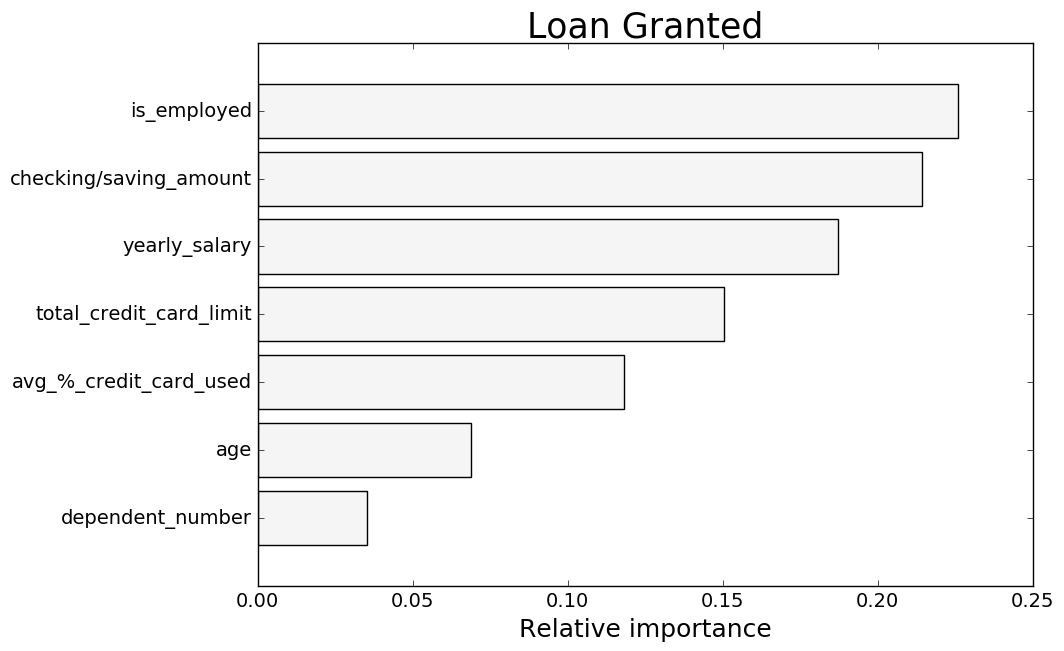

In [26]:
#combined features
plt.figure(figsize=(10,7))
plt.barh(range(len(feature_importance)),sorted(feature_importance),align='center', color = 'whitesmoke')
plt.yticks(range(len(feature_names)),feature_names)
plt.xticks(fontsize=14)
plt.xlabel('Relative importance', fontsize=18)
plt.title('Loan Granted', size = 25)
plt.yticks(fontsize=14)
plt.show()

ROC AUC: 0.78


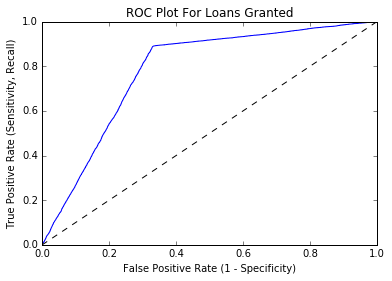

In [22]:
probabilities = GB.predict_proba(X_test_1)[:, 1]
# predicting 1's

fpr,tpr,threshold = roc_curve(y_test_1,probabilities)

# activating roc_curve 

roc_auc = auc(fpr, tpr)
print "ROC AUC: %0.2f" % roc_auc


plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Plot For Loans Granted")
plt.show()


In [24]:
y_predict_1 = GB.predict(X_test_1)
print "precision:", precision_score(y_test_1, y_predict_1)
print "recall:", recall_score(y_test_1, y_predict_1)
print "F1 score" , f1_score(y_test_1,y_predict_1)

precision: 0.702083333333
recall: 0.885864495887
F1 score 0.783338956998


In [20]:
loan_repaid = df[df['loan_granted']==1] # focusing on just loans granted

In [33]:
loan_repaid.head()

,loan_id,date,total_credit_card_limit,avg_%_credit_card_used,checking/saving_amount,is_employed,yearly_salary,age,dependent_number,loan_repaid,loan_granted
2,37,12/6/12,3800,0.59,12548,1,36000,27,1,1,1
5,48,2/21/12,3200,0.50,2562,1,2400,57,8,0,1
7,109,4/16/12,4800,1.02,2898,0,0,49,4,0,1
8,111,11/9/12,3800,0.78,4043,1,42600,61,1,0,1
9,120,6/19/12,4800,0.29,5986,1,29800,25,0,1,1


In [34]:
X_2 = loan_repaid[list(loan_repaid)[2:-2]]
y_2 = loan_repaid[list(loan_repaid)[-2]]
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2)
GB_2 = GradientBoostingClassifier()

In [35]:
list(loan_repaid)

['loan_id',
 'date',
 'total_credit_card_limit',
 'avg_%_credit_card_used',
 'checking/saving_amount',
 'is_employed',
 'yearly_salary',
 'age',
 'dependent_number',
 'loan_repaid',
 'loan_granted']

In [36]:
GB_2.fit(X_train_2,y_train_2)
GB_2.score(X_test_2,y_test_2)

0.89768339768339767

In [37]:
GB_2.predict_proba(X_2)

array([[ 0.00573579,  0.99426421],
       [ 0.86911681,  0.13088319],
       [ 0.96476479,  0.03523521],
       ..., 
       [ 0.00264541,  0.99735459],
       [ 0.02871915,  0.97128085],
       [ 0.00311185,  0.99688815]])

In [38]:
features = [[i,round(j,5)] for i,j in zip(X,GB_2.feature_importances_)]
features_sorted = sorted(features, key= lambda x: x[1] ,reverse=True)
features_sorted

[['checking/saving_amount', 0.46303],
 ['total_credit_card_limit', 0.17978],
 ['yearly_salary', 0.14294],
 ['avg_%_credit_card_used', 0.11552],
 ['dependent_number', 0.06085],
 ['is_employed', 0.02523],
 ['age', 0.01265]]

ROC AUC: 0.96


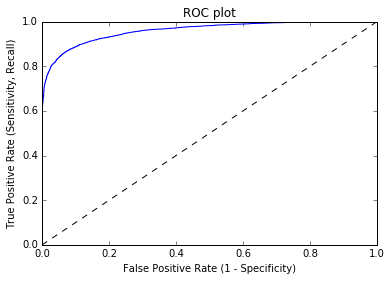

In [30]:
probabilities = GB_2.predict_proba(X_test_2)[:, 1]
# predicting 1's

fpr,tpr,threshold = roc_curve(y_test_2,probabilities)

# activating roc_curve 

roc_auc = auc(fpr, tpr)
print "ROC AUC: %0.2f" % roc_auc


plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC plot")
plt.show()

#produces a very good area under the curve score

In [31]:
feature_engineering_2 =  features_sorted
feature_names_2 = [ i[0] for i in feature_engineering_2]
feature_importance_2 = [ i[1] for i in feature_engineering_2]
feature_names_2.reverse()

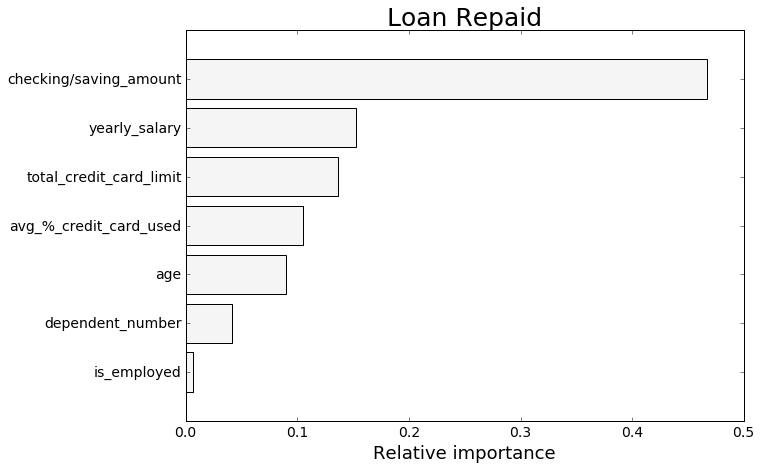

In [32]:
plt.figure(figsize=(10,7))
plt.barh(range(len(feature_importance_2)),sorted(feature_importance_2),align='center', color = 'whitesmoke')
plt.yticks(range(len(feature_names_2)),feature_names_2)
plt.xticks(fontsize=14)
plt.xlabel('Relative importance', fontsize=18)
plt.title('Loan Repaid', size = 25)
plt.yticks(fontsize=14)
plt.show()

In [33]:
y_predict_2 = GB_2.predict(X_test_2)
print "precision:", precision_score(y_test_2, y_predict_2)
print "recall:", recall_score(y_test_2, y_predict_2)
print "F1 score" , f1_score(y_test_2,y_predict_2)

precision: 0.928859060403
recall: 0.902098813714
F1 score 0.915283380729
